<center><h2>M1 MMA - Optimisation sous contraintes</h2><h3>Correction de la partie code du TP évalué (interro 3) : utilisation de l'algorithme Frank-Wolfe.</h3></center>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Utile seulement pour la réprésentation finale en fin de notebook
from mpl_toolkits.mplot3d import Axes3D
#from matplotlib.animation import FuncAnimation
from matplotlib.cm import ScalarMappable
from matplotlib.patches import Patch
#

Pour rappel, on implémente l'algorithme de FW qui produit une suite $(x_k)_{k\in\mathbb N}$ d'éléments de $C$ telle que pour $x_0\in C$ choisi par l'utilisateur, on a 
\begin{equation*}
	\forall k\in\mathbb N, \quad \begin{cases} s_k \in \mathrm{argmin}_{s\in C} \langle \nabla f(x_k), s\rangle,\\
							\lambda_k = \frac2{k+2},\\
							x_{k+1} = (1-\lambda_k)x_k + \lambda_k s_k.
						\end{cases}
\end{equation*}
Avec $f : x\in\mathbb{R}^n\mapsto \frac12\|Ax - y\|_2^2$ telle que $A \in \mathcal M_{m,n}(\mathbb{R})$, $y \in \mathbb{R}^m$ et $C$ est la boule unité fermée pour la norme $\ell_1$ i.e.
\begin{align*}
	C = \{x\in\mathbb{R}^n / \|x\|_1 \leq 1\}.
\end{align*}

Bien que l'implémentation réalisée ci-dessous de FW soit générale, on considère le cas particulier d'application correspondant à $n = m = 3$, $A = I_3$, $y = (3.4,3.3,3.3)$.

<b>Implémentation de l'algorithme Frank-Wolfe.</b>

Il prend notamment en argument la fonction "resoudre_linearisable" qui est utilsée dans le code comme une boîte noire. Cette fonction est censée renvoyer une solution du problème suivant
\begin{align}
    \min_{s\in C} \, \langle \nabla f(x_k), s\rangle, \tag{$\mathcal L$}
\end{align}
appelé dans la suite problème linéarisé. Cette fonction est à adapter en fonction des spécificités du problème d'optimisation (dépend de l'ensemble $C$ des contraintes). Nous en ferons une implémentation ultérieure dans la suite du document pour le problème qui nous concerne.

In [2]:
def frank_wolfe(x0, gradf, resoudre_linearisation, tol, max_iter = 10000):
    # Implémentation de l'algorithme de Frank-Wolfe
    
    # - x0 : position initiale, x0 \in C
    # - gradf : fonction codant le gradient de la fonction objectif.
    # - resoudre_linearisation : fonction implémentant une méthode de résolution du problème linéarisé.
    # Prend en argument le gradient de f en x
    # - tol : tolérance pour le critère d'arrêt
    # - max_iter : nombre maximium d'itérations autorisé
    
    k = 0
    x = x0
    x_list = [x] # va contenir la liste des itérées calculées par l'algorithme
    
    # On effectue un premier pas hors boucle de algo FW pour initialiser valeur intervenant dans critère d'arrêt
    gradfx = gradf(x)
    s = resoudre_linearisation(gradfx)
    pente = np.dot(gradfx, s - x) # <gradf(x), s - x> : "pente" de f dans la direction s - x
    pente_list = [] # va contenir la liste des pentes de f dans les directions s - x
    pente_list.append(pente)
    
    while pente <= -tol and k < max_iter: # pour un commentaire sur le critère d'arrêt, voir la partie illustrant la CV
        lbda = 2/(k + 2)
        x = (1 - lbda)*x + lbda*s # on met à jour l'itéré x comme défini dans l'algorithme FW
        gradfx = gradf(x) # on calcule le nouveau gradient en x
        s = resoudre_linearisation(gradfx) # on résoud le nouveau problème linéarisé min_{s\in C} <gradf(x), s>
        pente = np.dot(gradfx, s - x) # on calcule la nouvelle pente utilisée dans le critère d'arrêt
        x_list.append(x)
        pente_list.append(pente)
        k += 1
    return x, x_list, pente_list

<b>Définitions des paramètres du problème d'optimisation.</b>

In [3]:
# paramètres du problème d'optimisation
m, n = 3, 3
A = np.eye(n)
al1 = 0.4#np.random.rand()
al2 = 0.3#np.random.rand()
al3 = 1 - al1 - al2
al = np.array([al1, al2, al3]) # alpha est sur la face contenant e_1, e_2 et e_3
y = np.array([al1, al2, al3]) + 3*np.array([1, 1, 1]) # b est choisi de sorte que \nabla f(alpha) in T_C(alpha)^*

def f(x):
    # renvoie la valeur de la fonction objectif f en x
    return .5*np.linalg.norm(np.dot(A, x) - y)**2
def gradf(x):
    # Cette implémentation est relativelement optimisé si m << n car a une complexité en O(mn).
    # Par contre si m >> n, il vaut mieux stocker une bonne fois pour toute B = A^T A qui est de taille n x n
    # ainsi que c = A^T b puis implémenter np.dot(B, x) - c qui a une complexité en O(n^2) (meilleure que O(mn))
    return np.dot(A.transpose(), np.dot(A, x) - y)

<b>Implémentation de la fonction résolvant le problème linéarisé $(\mathcal L)$, dans le cas de l'ensemble $C$ précisé au début de ce document (boule unité fermé de la norme $\ell_1$).</b>

In [4]:
def resoudre_linearisation(gradfx):
    # renvoie une solution de min_{s \in C} <nabla f(x), s> où C est la boule unité norme ell_1
    k0 = (-abs(gradfx)).argmin() # k0 \in argmin_k (-|v_k|) où v = gradfx. Or min_k (-|v_k|) = - max_k |v_k|,
    # donc k0 \in argmax_k |v_k|.
    
    # e = e_{k0}
    e = np.zeros(n)
    e[k0] = 1.0
    
    # On renvoie -sign(v_{k0}) e_{k0}
    if gradfx[k0] > 0:
        return -e
    else:
        return e

<b>Utilisation de l'algorithme dans le cas particulier choisi.</b>

In [5]:
# on résoud le problème d'optim grâce à l'algo FW
x0 = np.zeros(n) # on initialise l'algorithme en 0_{R^n} qui est bien dans C
x, x_list, pente_list = frank_wolfe(x0, gradf, resoudre_linearisation, 1e-4)

print("Solution approchée trouvée : ", x)
print("Nombre d'itérations : ", len(x_list))

Solution approchée trouvée :  [0.39988904 0.30019417 0.29991678]
Nombre d'itérations :  3609


<b>Illustration de la convergence</b>

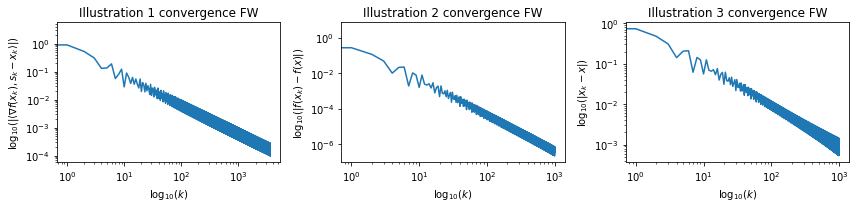

In [6]:
plt.figure(figsize = (12, 3))
plt.subplot(131)
plt.loglog(abs(np.array(pente_list)))
plt.xlabel(r"$\log_{10}(k)$")
plt.ylabel(r"$\log_{10}(|\langle \nabla f(x_k), s_k - x_k\rangle|)$")
plt.title("Illustration 1 convergence FW")

plt.subplot(132)
plt.loglog([abs(f(x_list[i]) - f(x)) for i in range(1000)])
plt.xlabel(r"$\log_{10}(k)$")
plt.ylabel(r"$\log_{10}(|f(x_k) - f(x)|)$")
plt.title("Illustration 2 convergence FW")

plt.subplot(133)
plt.loglog([np.linalg.norm(x_list[i] - x) for i in range(1000)])
plt.xlabel(r"$\log_{10}(k)$")
plt.ylabel(r"$\log_{10}(\|x_k - x\|)$")
plt.title("Illustration 3 convergence FW")

plt.tight_layout()
plt.show()

On a représenté trois quantités permettant d'observer la convergence de la suite produite par l'algorithme Frank-Wolfe. Les deuxième et troisième figures sont classiques. La première l'est moins. Voir le document pdf associé aux questions théoriques. Cette discussion a un lien avec le critère d'arrêt choisi dans la fonction FW.

Les axes de ces figures sont tous les deux en échelle logarithmique. Pour rappel, mettre uniquement l'axe des ordonnées en échelle $\log$ (grâce à la fonction plt.semilogy) permet d'illustrer les convergence linéaires i.e. celles dont l'erreur se comporte en $\alpha^k$ avec $0<\alpha<1$, puisqu'alors on doit observer (au moins asymptotiquement) une droite de pente $\log(\alpha) < 0$. Mettre les deux axes en échelle $\log$ permet d'illustrer les convergences sous-linéaires du type dont l'erreur est en $\frac1{k^\alpha}$ avec $\alpha > 0$, puisqu'alors le $\log$ de l'erreur est en $-\alpha \log(k)$ et le comportement de cette quantité dépend linéairement de $\log(k)$ (d'où le fait de passer également l'axe des abscisse en $\log$).

On remarque que pour chacun de ces graphes, on observe un comportement asymptotique linéaire dont les pentes semblent être $-1$ pour les graphes 1 et 3, donc $\alpha = 1$, mais $-2$ pour le deuxième. Ainsi la vitesse de convergence de la suite $(f(x_k))_k$ semble être en $\frac{1}{k^2}$ et celle de $(x_k)_k$ sont en $\frac1k$. Le comportement théorique attendue pour la vitesse de convergence de $(f(x_k))_k$ est dans le pire des cas en $\frac1k$ (voir la correction de l'examen 2021/2022).

<b>Pour le fun, voici une représentation en $3$D de la suite $(x_k)_k$ produite par l'algorithme Frank-Wolfe pour le problème résolu.</b>

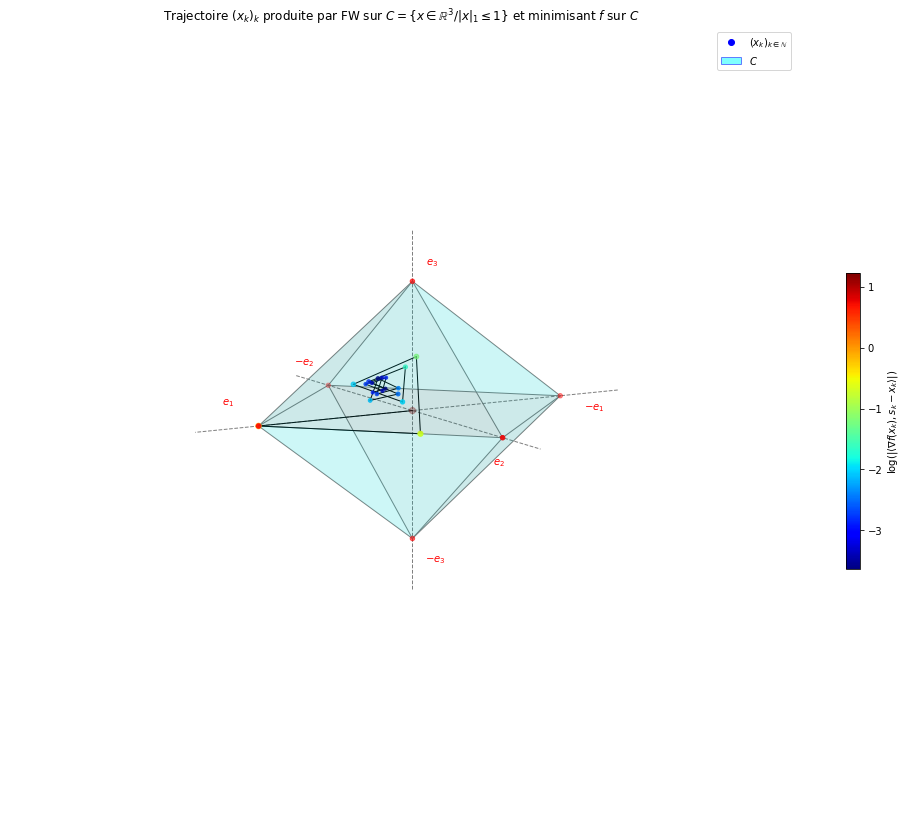

In [13]:
##############################################
# Affichage de la trajectoire (x_k)_k dans C #
##############################################

# L'ensemble C est la boule unité fermé pour la norme ell_1, en dimension 3 c'est un octaèdre !
# Je remercie chatGPT qui m'a aidé à écrire ce code.

# Coordonnées des sommets de l'octaèdre
vertices = np.array([[1, 0, 0],
                     [-1, 0, 0],
                     [0, 1, 0],
                     [0, -1, 0],
                     [0, 0, 1],
                     [0, 0, -1]])

# Définition des arêtes de l'octaèdre
edges = [(0, 2), (0, 4), (0, 3), (0, 5),
         (1, 2), (1, 4), (1, 3), (1, 5),
         (2, 4), (2, 5), (3, 4), (3, 5)]

# Tracé de l'octaèdre
fig = plt.figure(figsize = (14, 14))
ax = fig.add_subplot(111, projection = '3d')

# Affichage des sommets
ax.scatter(vertices[:, 0], vertices[:, 1], vertices[:, 2], c = 'r', marker = 'o')

# Affichage des arêtes
for edge in edges:
    x = [vertices[edge[0], 0], vertices[edge[1], 0]]
    y = [vertices[edge[0], 1], vertices[edge[1], 1]]
    z = [vertices[edge[0], 2], vertices[edge[1], 2]]
    ax.plot(x, y, z, color = 'gray', lw = 1.0)

# Définition des faces de l'octaèdre
faces = [[vertices[i] for i in [0, 2, 4]],
         [vertices[i] for i in [0, 4, 3]],
         [vertices[i] for i in [0, 3, 5]],
         [vertices[i] for i in [0, 5, 2]],
         [vertices[i] for i in [1, 2, 4]],
         [vertices[i] for i in [1, 4, 3]],
         [vertices[i] for i in [1, 3, 5]],
         [vertices[i] for i in [1, 5, 2]]]

for face in faces:
    x, y, z = np.array(face).T
    ax.plot_trisurf(x, y, z, color = 'cyan', alpha = 0.1)

# Annotation des sommets de l'octaèdre
ax.text(1.15, -0.15, 0.15, r'$e_1$', color = 'red')
ax.text(-1.1, 0.1, -0.1, r'$-e_1$', color = 'red')
ax.text(0.15, 1.15, -0.15, r'$e_2$', color = 'red')
ax.text(0.15, -1.15, 0.15, r'$-e_2$', color = 'red')
ax.text(0.0, 0.15, 1.15, r'$e_3$', color = 'red')
ax.text(0.0, 0.15, -1.15, r'$-e_3$', color = 'red')

# Affichage des axes x, y, z
ax.plot([-1.4, 1.4], [0, 0], [0, 0], color = 'gray', linestyle = '--', lw = 1.0)
ax.plot([0, 0], [-1.4, 1.4], [0, 0], color = 'gray', linestyle = '--', lw = 1.0)
ax.plot([0, 0], [0, 0], [-1.4, 1.4], color = 'gray', linestyle = '--', lw = 1.0)

# Suppression du fond
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.grid(False)

# Ajout d'un titre
ax.set_title(r"Trajectoire $(x_k)_k$ produite par FW sur $C = \{x\in\mathbb{R}^3 / \|x\|_1 \leq 1\}$ et minimisant $f$ sur $C$")

# Réglage des limites des axes
ax.set_xlim([-1.4, 1.4])
ax.set_ylim([-1.4, 1.4])
ax.set_zlim([-1.4, 1.4])

# Suppression des axes sur les côtés
ax.set_axis_off()

# Tracé des points (x_k)_k avec des tailles de marker diminuant avec k et des couleurs basées sur la CV de la suite
number_points = np.min([20, len(x_list)])
sizes = 100 /(np.log(5 + np.arange(number_points))**2)  # Tailles diminuant avec l'indice
colors = [np.log(abs(pente_list[i])) for i in range(number_points)]
ax.scatter([x_list[i][0] for i in range(number_points)], [x_list[i][1] for i in range(number_points)], [x_list[i][2] for i in range(number_points)], c=colors, cmap='jet', marker='o', s=sizes)

# Création de l'échelle de couleur pour la légende des points
sm = ScalarMappable(cmap = 'jet')
sm.set_array(colors)
cbar = plt.colorbar(sm, shrink = 0.3)
cbar.set_label(r'$\log(|\langle \nabla f(x_k), s_k - x_k \rangle|)$')

# Tracé des segments reliant les points
for i in range(number_points - 1):
    ax.plot([x_list[i][0], x_list[i+1][0]], [x_list[i][1], x_list[i+1][1]], [x_list[i][2], x_list[i+1][2]], color="black", lw = 1)

# Légende pour les (x_k)_k
legend_labels_scatter = [r"$(x_k)_{k\in\mathbb{N}}$"]
scatter_proxy = plt.Line2D([0],[0], linestyle = "none", c = 'b', marker = 'o')

# Légende ensemble C
legend_C = [Patch(facecolor='cyan', edgecolor='b', alpha=0.5, label = r'$C$')]
label_C = [r'$C$']

# Fusion des anciens et nouveaux éléments de légende
handles = [scatter_proxy] + legend_C
labels = legend_labels_scatter + label_C

# Ajout de la légende combinée
ax.legend(handles = handles, labels = labels)

# Rotation du plot
ax.view_init(elev = 10, azim = 60) # modifier ces paramètres d'orientation pour faire modifier l'angle de vue de la figure

plt.tight_layout()
plt.show()

On remarque que pour tout $k\geq 1$, $x_k$ appartient à la face de l'octaèdre contenant les sommets $e_1$, $e_2$ et $e_3$. Géométriquement le problème d'optimisation pour les valeurs de $A$, $y$ choisies revient à projeter $y\notin C$, sur $C$. Ainsi on sait que l'unique solution résultat de cette projection (et solution de notre problème d'optim) est sur la frontière de $C$ i.e. appartient aux $x$ tels que $\|x\|_1 = 1$.

En fait $y$ a été choisi de sorte que $y = (0.4, 0.3, 0.3) + 3(1,1,1)$. Or on peut montrer que $T_C((0.4,0.3,0.3))^\star = \mathbb{R}_-(1,1,1)$ ($(1,1,1)$ est orthogonal à la face de l'octaèdre contenant les sommets $e_1$, $e_2$ et $e_3$). Donc $\nabla f((0.4,0.3,0.3)) = (0.4,0.3,0.3) - y = -3(1,1,1) \in T_C((0.4,0.3,0.3))^\star$. La projection de $y$ sur $C$ est $(0.4,0.3,0.3)$. L'algorithme est donc censé converger vers ce point ! Ce qui est bien le cas.